<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/angelo_albumentations/STEP_3B_PIDNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [ ]:
!pip install torchmetrics
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
from google.colab import drive
import os

!git clone -b angelo_albumentations --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git

!cp AML_2025_project4/utils.py .

drive.mount('/content/drive')

Cloning into 'AML_2025_project4'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 78 (delta 26), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (78/78), 7.71 MiB | 14.72 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Mounted at /content/drive


In [ ]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [ ]:
import tqdm

from utils import get_loveDA

paths = get_loveDA(verbose=True)
print(paths)

TRAINING_PATH_URBAN = paths["training_urban"]
TRAINING_PATH_RURAL = paths["training_rural"]
VAL_PATH_URBAN = paths["validation_urban"]
VAL_PATH_RURAL = paths["validation_rural"]

Extracting training...
training extracted!
Extracting validation...
validation extracted!
Extraction check completed!
{'training_urban': '/content/dataset/Train/Urban', 'training_rural': '/content/dataset/Train/Rural', 'validation_urban': '/content/dataset/Val/Urban', 'validation_rural': '/content/dataset/Val/Rural'}


In [ ]:
SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

RESIZE = 512

BATCH_SIZE = 16

EPOCHS = 20

SEED = 42

STEP_SIZE = 5

GAMMA = 0.1

LR = 0.01

P = 0.5 # probabilità augmentation

# Define and instantiate

### Define PIDnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False



class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

# Dataset & dataloader

## Dataset definition

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform, augmentation=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.augmentation = augmentation

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])


        # Read an image with OpenCV
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)


        if self.augmentation:
          transformed = self.augmentation(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]


        mask_np = np.array(mask)

        edge = cv2.Canny(mask_np, 0.1, 0.2)

        kernel = np.ones((3, 3), np.uint8)  # Kernel for dilation

        edge = edge[6:-6, 6:-6]
        edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
        boundaries = cv2.dilate(edge, kernel, iterations=1)  # Dilate edges
        boundaries = (boundaries > 50) * 1.0 # boundaries matrix is float with 1.0 or 0.0

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        boundaries_tensor = torch.as_tensor(boundaries, dtype=torch.float32)

        #return image, mask, boundaries_tensor  # Return (image, mask) pair
        return image, mask, boundaries_tensor  # Return (image, mask) pair

## Define transformations
(using albumentations)

In [ ]:
# Define transformations for images & masks
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import v2 as T
import cv2
import itertools


resize_transform = A.Compose([
    A.Resize(height=RESIZE, width=RESIZE, p=1),
    A.ToFloat(),
    ToTensorV2()
])

alb_aug0 = A.HorizontalFlip(p=P)
alb_aug1 = A.GaussianBlur(p=P, sigma_limit=(0.5, 3.0))
alb_aug2 = A.ElasticTransform(alpha=1300, sigma=20, p=P)
alb_aug3 = A.HueSaturationValue(
    hue_shift_limit=20,
    sat_shift_limit=30,
    val_shift_limit=20,
    p=P
)

base_augmentations = [alb_aug0,
                  alb_aug1,
                  alb_aug2,
                  alb_aug3]

# Selezione delle 6 combinazioni specifiche
augmentations = [
    A.Compose([alb_aug0]),  # Solo orizzontale flip
    A.Compose([alb_aug1]),  # Solo gaussian blur
    A.Compose([alb_aug2]),  # Solo elastic transform
    A.Compose([alb_aug3]),  # Solo hue, saturation, value
    A.Compose([alb_aug0, alb_aug1]),  # Flip + Gaussian blur
    A.Compose([alb_aug2, alb_aug3])   # Elastic transform + Hue, saturation, value
]

## Dataset instantiation

In [ ]:
# Create dataset objects
DOMAIN_SHIFT = True

train_datasets = []

for i, augmentation in enumerate(augmentations):

  train_dataset = SegmentationDataset(TRAINING_PATH_URBAN + "/images_png", TRAINING_PATH_URBAN + "/masks_png",
                                      transform=resize_transform, augmentation=augmentation)
  train_datasets.append(train_dataset)

if not DOMAIN_SHIFT:
  val_dataset = SegmentationDataset(VAL_PATH_URBAN + "/images_png", VAL_PATH_URBAN + "/masks_png",
                                    transform=resize_transform)
else:
  val_dataset = SegmentationDataset(VAL_PATH_RURAL + "/images_png", VAL_PATH_RURAL + "/masks_png",
                                    transform=resize_transform)

## Loader instantiation

In [ ]:
# Create DataLoaders
train_loaders = []

for dataset in train_datasets:
  train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
  train_loaders.append(train_loader)


train_loader = train_loaders[2] # provo con dataloader modifica saturation hue
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

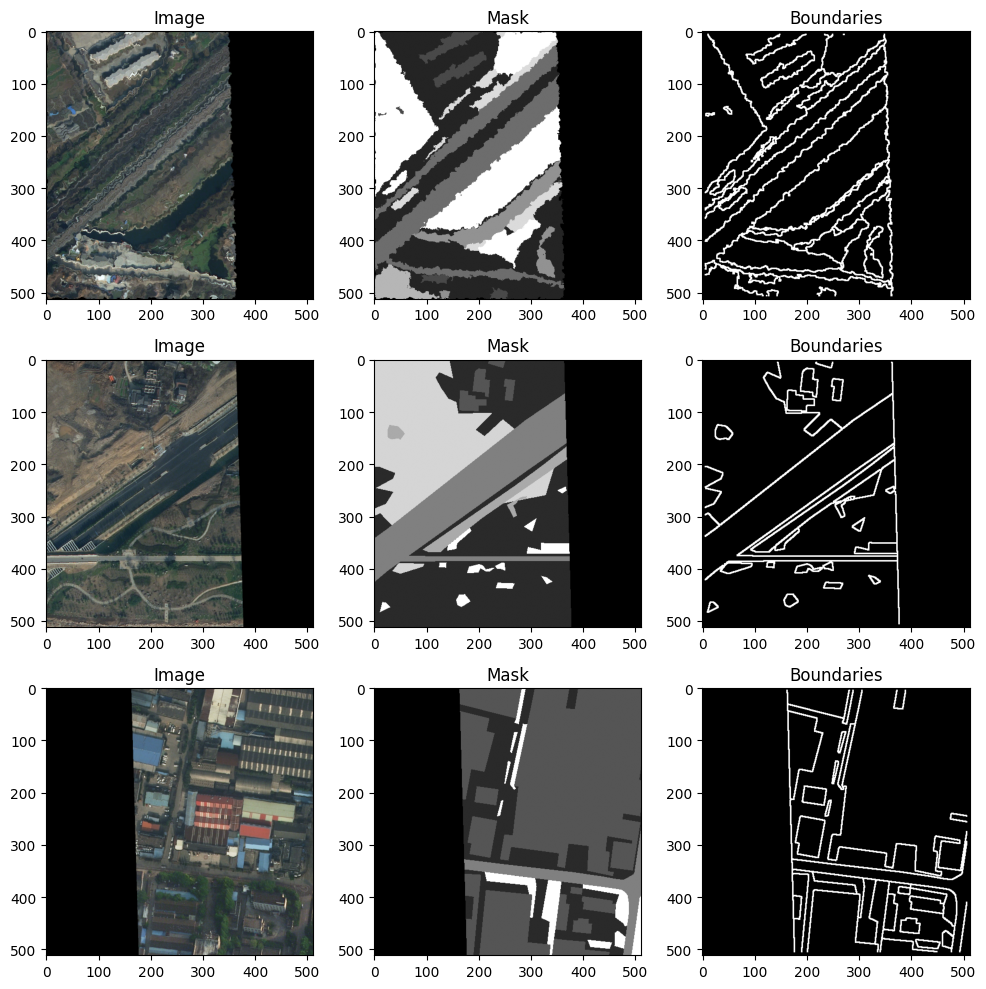

In [ ]:
from utils import show
from matplotlib import pyplot as plt

batch = next(iter(train_loader))  # (images, masks, boundaries)
images, masks, boundaries = batch  # Unpack the batch

fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3 images, each with RGB, mask, and boundary

for i in range(3):  # Show first 3 images

    # Permute the dimensions of the image tensor to (height, width, channels)
    image_np = images[i].cpu().numpy().transpose(1, 2, 0)

    axes[i, 0].imshow(image_np) # Display the image with the correct shape
    axes[i, 0].set_title("Image")

    axes[i, 1].imshow(masks[i].cpu().numpy(), cmap="gray")  # Show mask
    axes[i, 1].set_title("Mask")

    axes[i, 2].imshow(boundaries[i].cpu().numpy(), cmap="gray")  # Show boundaries
    axes[i, 2].set_title("Boundaries")


plt.tight_layout()
plt.show()

### Instantiate model

In [ ]:
import gdown

if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)

  print("imagenet-pretrained pidnet weights downloaded")


class Config:
  class MODEL:
      NAME = 'pidnet_s'
      PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
  class DATASET:
      NUM_CLASSES = NUM_CLASSES

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)
next(model.parameters()).device

# Instanzia n modelli (uno per ogni dataloader)
models = [get_seg_model(cfg, imgnet_pretrained=True) for _ in train_loaders]

Downloading...
From: https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-
To: /content/PIDNet_S_ImageNet.pth.tar
100%|██████████| 38.1M/38.1M [00:00<00:00, 197MB/s]


imagenet-pretrained pidnet weights downloaded


# Training Phase

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print(device);

cuda


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Extra Semantic Loss (Classica CrossEntropy Loss)
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target):
        return self.loss(pred, target)

# 2. Weighted Binary Cross Entropy per i bordi
class WeightedBinaryCrossEntropy(nn.Module):
    def __init__(self, pos_weight=20.0):  # Peso λ1 sui bordi
        super(WeightedBinaryCrossEntropy, self).__init__()
        self.loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))

    def forward(self, pred, target):
        return self.loss(pred, target)

# 3. Boundary-Aware CrossEntropy Loss
class BoundaryAwareCELoss(nn.Module):
    def __init__(self, weight=None):
        super(BoundaryAwareCELoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target, boundary_mask):
        ce_loss = self.loss(pred, target)
        return torch.mean(ce_loss * boundary_mask)  # Pesa i bordi

# 4. BAS-Loss per segmentazione e detection dei bordi
class BASLoss(nn.Module):
    def __init__(self, threshold=0.8):
        super(BASLoss, self).__init__()
        self.threshold = threshold

    def forward(self, boundary_head, pred, target):
        boundary_mask = (boundary_head > self.threshold).float()  # Maschera bordi
        log_probs = F.log_softmax(pred, dim=1)

        # Reshape per compatibilità
        batch_size, num_classes, H, W = log_probs.shape
        log_probs = log_probs.permute(0, 2, 3, 1).reshape(-1, num_classes)  # [B*H*W, num_classes]
        target = target.reshape(-1)  # [B*H*W]
        boundary_mask = boundary_mask.reshape(-1)  # [B*H*W]

        # Applica la perdita solo ai bordi
        loss = -torch.sum(boundary_mask * log_probs[torch.arange(target.shape[0]), target])

        # Normalizza rispetto al numero di pixel nei bordi (evita divisioni per 0)
        return loss / (boundary_mask.sum() + 1e-6)

# 5. PIDNet Loss Totale
class PIDNetLoss(nn.Module):
    def __init__(self, lambda_0=0.4, lambda_1=20, lambda_2=1, lambda_3=1, threshold=0.8):
        super(PIDNetLoss, self).__init__()
        self.ce_loss = CrossEntropyLoss()
        self.wbce_loss = WeightedBinaryCrossEntropy(pos_weight=lambda_1)
        self.boundary_ce_loss = BoundaryAwareCELoss()
        self.bas_loss = BASLoss(threshold)

        self.lambda_0 = lambda_0
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_3 = lambda_3

    def forward(self, pred, target, boundary_head, boundary_mask):
        """
        pred: output principale (B, C, H, W)
        target: ground truth segmentazione (B, H, W)
        boundary_head: predizione dei bordi (B, 1, H, W)
        boundary_mask: ground truth dei bordi (B, 1, H, W)
        """
        L0 = self.ce_loss(pred, target)  # Extra Semantic Loss
        L1 = self.wbce_loss(boundary_head, boundary_mask.unsqueeze(1))  # Weighted BCE
        L2 = self.boundary_ce_loss(pred, target, boundary_mask)  # Boundary-Aware CE
        L3 = self.bas_loss(boundary_head, pred, target)  # BAS-Loss

        loss = (self.lambda_0 * L0 +
                self.lambda_1 * L1 +
                self.lambda_2 * L2 +
                self.lambda_3 * L3)

        return loss


In [ ]:
'''
batch = next(iter(train_loader))  # (images, masks, boundaries)
X, y, boundaries = batch  # Unpack the batch
X = X.to(device)
y = y.to(device)

print("X =", X.shape)
print("y =", y.shape)
print("boundary =", boundaries.shape)
print(X.dtype)

# Output del modello
outputs = model(X)  # PIDNet può restituire [x_extra_p, x_, x_extra_d] se augment=True

# Upscale trough bilinear interpolation -> riporto le dimensioni dell'output a quelli originali
# Quindi passiamo da 64 x 64 a 512 x 512
h, w = boundaries.size(1), boundaries.size(2)
ph, pw = outputs[0].size(2), outputs[0].size(3)
if ph != h or pw != w:
    for i in range(len(outputs)):
        outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

pred_p, pred_main, boundary_head = outputs  # P, I, D branches

#print("outputs[0] =", outputs[0].shape) # pred_p
print("outputs[1] =", outputs[1].shape) # pred_main
print("outputs[2] =", outputs[2].shape) # Ramo D (boundary_head)

preds = torch.argmax(pred_main, dim=1)
print("preds =", preds.shape)
'''

'\nbatch = next(iter(train_loader))  # (images, masks, boundaries)\nX, y, boundaries = batch  # Unpack the batch\nX = X.to(device)\ny = y.to(device)\n\nprint("X =", X.shape)\nprint("y =", y.shape)\nprint("boundary =", boundaries.shape)\nprint(X.dtype)\n\n# Output del modello\noutputs = model(X)  # PIDNet può restituire [x_extra_p, x_, x_extra_d] se augment=True\n\n# Upscale trough bilinear interpolation -> riporto le dimensioni dell\'output a quelli originali\n# Quindi passiamo da 64 x 64 a 512 x 512\nh, w = boundaries.size(1), boundaries.size(2)\nph, pw = outputs[0].size(2), outputs[0].size(3)\nif ph != h or pw != w:\n    for i in range(len(outputs)):\n        outputs[i] = F.interpolate(outputs[i], size=(h, w), mode=\'bilinear\', align_corners=True)\n\npred_p, pred_main, boundary_head = outputs  # P, I, D branches\n\n#print("outputs[0] =", outputs[0].shape) # pred_p\nprint("outputs[1] =", outputs[1].shape) # pred_main\nprint("outputs[2] =", outputs[2].shape) # Ramo D (boundary_head)\n

In [ ]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU

os.makedirs("/content/drive/MyDrive/AML_project/checkpoints", exist_ok=True)

torch.manual_seed(SEED)

num_classes = 7  # Cambia in base al tuo dataset
#miou_classes = MeanIoU(num_classes=num_classes, per_class=True).to(device)
#miou_overall = MeanIoU(num_classes=num_classes).to(device)
k = 0
miou_results = []
model_train_loader = zip(models, train_loaders)
for model, train_loader in model_train_loader:
  model.to(device)
  loss_fn = PIDNetLoss()

  for epoch in range(EPOCHS):
      model.train()
      train_loss = 0

      total_train_samples = 0

      batch_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}", ncols=100)

      for batch, (X, y, boundary_mask) in batch_pbar:
          X = X.to(device)
          y = y.to(device)
          boundary_mask = boundary_mask.to(device)

          # Output del modello
          outputs = model(X)  # PIDNet può restituire [x_extra_p, x_, x_extra_d] se augment=True

          # Upscale trough bilinear interpolation -> riporto le dimensioni dell'output a quelli originali
          # Quindi passiamo da 64 x 64 della rete a 512 x 512
          h, w = boundary_mask.size(1), boundary_mask.size(2)
          ph, pw = outputs[0].size(2), outputs[0].size(3)
          if ph != h or pw != w:
              for i in range(len(outputs)):
                  outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

          if model.augment:
              pred_p, pred_main, boundary_head = outputs  # P, I, D branches
          else:
              pred_main = outputs
              boundary_head = None  # Nessuna branch D se augment=False

          # Calcolo della loss
          loss = loss_fn(pred_main, y, boundary_head, boundary_mask)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_train_samples += X.size(0)

          train_loss += loss.item()
          batch_pbar.set_postfix(loss=loss.item())

      #avg_train_loss = train_loss / len(train_loader)

      #total_samples = sum(len(batch[0]) for batch in train_loader)
      avg_train_loss = train_loss / total_train_samples


      print(f"Epoch {epoch+1}/{EPOCHS} - Training Loss: {avg_train_loss}")


      # **Validazione**
      model.eval()
      val_loss = 0

      total_union = torch.zeros(NUM_CLASSES).to(device)
      total_intersection = torch.zeros(NUM_CLASSES).to(device)

      import torch.nn.functional as F

      total_val_samples = 0

      with torch.inference_mode():
          for X_val, y_val, boundary_mask in val_loader:
              X_val = X_val.to(device)
              y_val = y_val.to(device)
              boundary_mask = boundary_mask.to(device)

              # Output del modello
              outputs = model(X_val)

              ## Upscale trough bilinear interpolation
              h, w = boundary_mask.size(1), boundary_mask.size(2)
              ph, pw = outputs[0].size(2), outputs[0].size(3)
              if ph != h or pw != w:
                  for i in range(len(outputs)):
                      outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

              if model.augment:
                  pred_p, pred_main, boundary_head = outputs
              else:
                  pred_main = outputs
                  boundary_head = None

              output_class_per_pixel = torch.argmax(outputs[1], dim=1)

              for predicted, target in zip(output_class_per_pixel, y_val):
                for i in range(NUM_CLASSES):
                  total_intersection[i] += torch.sum(torch.logical_and(predicted == i, target == i))
                  total_union[i] += torch.sum(torch.logical_or(predicted == i, target == i))


              # Calcola la loss
              loss = loss_fn(pred_main, y_val, boundary_head, boundary_mask)

              val_loss += loss.item()

              total_val_samples += X_val.size(0)

      avg_val_loss = val_loss / total_val_samples

      intersection_over_union = total_intersection / total_union
      # per class
      for i, iou in enumerate(intersection_over_union):
          class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
          print(f'{class_name} IoU: {iou:.4f}')

      miou = torch.mean(intersection_over_union)
      print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou}")

      if epoch % 5 == 0:
        print(scheduler.get_last_lr())

      ## steps the scheduler
      scheduler.step()

  checkpoint_path = f"/content/drive/MyDrive/AML_project/checkpoints/model_PIDNET_3B_{k}.pth"
  torch.save(model.state_dict(), checkpoint_path)
  print(f"Modello salvato: {checkpoint_path}")

  # Crea dizionario dei risultati per questo modello
  model_miou_dict = {
      "model_id": k,
      "miou_per_class": {
          list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(j)]: float(iou)
          for j, iou in enumerate(intersection_over_union)
      },
      "miou_overall": float(miou)
  }

  # Aggiungilo alla lista dei risultati
  miou_results.append(model_miou_dict)
  k = k  + 1

Epoch 1/20: 100%|█████████████████████████████████████████| 73/73 [00:20<00:00,  3.65it/s, loss=152]

Epoch 1/20 - Training Loss: 8.18253236658433


background IoU: 0.1182
building IoU: 0.0264
road IoU: 0.0238
water IoU: 0.0064
barren IoU: 0.0266
forest IoU: 0.0128
agriculture IoU: 0.1003
Epoch 1/20 - Validation Loss: 5.657303564010128 - mIoU: 0.04492573440074921
[0.01]


Epoch 2/20: 100%|█████████████████████████████████████████| 73/73 [00:19<00:00,  3.75it/s, loss=104]

Epoch 2/20 - Training Loss: 8.129598280962776


background IoU: 0.1278
building IoU: 0.0281
road IoU: 0.0235
water IoU: 0.0055
barren IoU: 0.0299
forest IoU: 0.0148
agriculture IoU: 0.1008
Epoch 2/20 - Validation Loss: 5.664972166861257 - mIoU: 0.047198787331581116


Epoch 3/20: 100%|█████████████████████████████████████████| 73/73 [00:19<00:00,  3.80it/s, loss=130]

Epoch 3/20 - Training Loss: 8.17465246919942


background IoU: 0.1152
building IoU: 0.0256
road IoU: 0.0235
water IoU: 0.0063
barren IoU: 0.0275
forest IoU: 0.0124
agriculture IoU: 0.1027
Epoch 3/20 - Validation Loss: 5.762349474814631 - mIoU: 0.04475678130984306


Epoch 4/20: 100%|█████████████████████████████████████████| 73/73 [00:19<00:00,  3.74it/s, loss=139]

Epoch 4/20 - Training Loss: 8.209985898027783


background IoU: 0.1199
building IoU: 0.0278
road IoU: 0.0237
water IoU: 0.0061
barren IoU: 0.0273
forest IoU: 0.0138
agriculture IoU: 0.1033
Epoch 4/20 - Validation Loss: 5.638955639254663 - mIoU: 0.04600047320127487


Epoch 5/20: 100%|█████████████████████████████████████████| 73/73 [00:19<00:00,  3.76it/s, loss=135]

Epoch 5/20 - Training Loss: 8.16927976509279


background IoU: 0.1155
building IoU: 0.0273
road IoU: 0.0235
water IoU: 0.0067
barren IoU: 0.0257
forest IoU: 0.0127
agriculture IoU: 0.1003
Epoch 5/20 - Validation Loss: 5.704384073134391 - mIoU: 0.04455427825450897


Epoch 6/20: 100%|█████████████████████████████████████████| 73/73 [00:19<00:00,  3.75it/s, loss=133]

Epoch 6/20 - Training Loss: 8.161866910729854


background IoU: 0.1200
building IoU: 0.0249
road IoU: 0.0239
water IoU: 0.0056
barren IoU: 0.0287
forest IoU: 0.0132
agriculture IoU: 0.1015
Epoch 6/20 - Validation Loss: 5.71181042732731 - mIoU: 0.04539494961500168
[0.001]


Epoch 7/20: 100%|█████████████████████████████████████████| 73/73 [00:19<00:00,  3.78it/s, loss=103]

Epoch 7/20 - Training Loss: 8.146690896638125


background IoU: 0.1190
building IoU: 0.0257
road IoU: 0.0237
water IoU: 0.0070
barren IoU: 0.0266
forest IoU: 0.0143
agriculture IoU: 0.1077
Epoch 7/20 - Validation Loss: 5.73199813596664 - mIoU: 0.04626859351992607


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.76it/s, loss=99.3]

Epoch 8/20 - Training Loss: 8.163404081931988


background IoU: 0.1191
building IoU: 0.0269
road IoU: 0.0235
water IoU: 0.0062
barren IoU: 0.0283
forest IoU: 0.0130
agriculture IoU: 0.1042
Epoch 8/20 - Validation Loss: 5.692984788648544 - mIoU: 0.04587767273187637


Epoch 9/20: 100%|█████████████████████████████████████████| 73/73 [00:19<00:00,  3.80it/s, loss=156]

Epoch 9/20 - Training Loss: 8.183330562287962


background IoU: 0.1313
building IoU: 0.0272
road IoU: 0.0238
water IoU: 0.0054
barren IoU: 0.0303
forest IoU: 0.0140
agriculture IoU: 0.1019
Epoch 9/20 - Validation Loss: 5.66256429303077 - mIoU: 0.04769538342952728


Epoch 10/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.77it/s, loss=151]

Epoch 10/20 - Training Loss: 8.19405954354362


background IoU: 0.1235
building IoU: 0.0246
road IoU: 0.0239
water IoU: 0.0061
barren IoU: 0.0293
forest IoU: 0.0133
agriculture IoU: 0.1060
Epoch 10/20 - Validation Loss: 5.764593562772197 - mIoU: 0.046674031764268875


Epoch 11/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.77it/s, loss=140]

Epoch 11/20 - Training Loss: 8.18792201903452


background IoU: 0.1201
building IoU: 0.0243
road IoU: 0.0236
water IoU: 0.0064
barren IoU: 0.0265
forest IoU: 0.0137
agriculture IoU: 0.0994
Epoch 11/20 - Validation Loss: 5.6891298909341135 - mIoU: 0.04487281292676926
[0.0001]


Epoch 12/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.75it/s, loss=151]

Epoch 12/20 - Training Loss: 8.196892233455882


background IoU: 0.1328
building IoU: 0.0253
road IoU: 0.0243
water IoU: 0.0058
barren IoU: 0.0281
forest IoU: 0.0148
agriculture IoU: 0.0966
Epoch 12/20 - Validation Loss: 5.732268494944418 - mIoU: 0.0468176044523716


Epoch 13/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.78it/s, loss=146]

Epoch 13/20 - Training Loss: 8.182646840501409


background IoU: 0.1138
building IoU: 0.0247
road IoU: 0.0234
water IoU: 0.0060
barren IoU: 0.0282
forest IoU: 0.0137
agriculture IoU: 0.0999
Epoch 13/20 - Validation Loss: 5.68404794508411 - mIoU: 0.04424643889069557


Epoch 14/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.77it/s, loss=107]

Epoch 14/20 - Training Loss: 8.166059804210201


background IoU: 0.1181
building IoU: 0.0260
road IoU: 0.0235
water IoU: 0.0059
barren IoU: 0.0243
forest IoU: 0.0133
agriculture IoU: 0.1037
Epoch 14/20 - Validation Loss: 5.572707083917433 - mIoU: 0.044983141124248505


Epoch 15/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.74it/s, loss=120]

Epoch 15/20 - Training Loss: 8.186041485479546


background IoU: 0.1226
building IoU: 0.0268
road IoU: 0.0236
water IoU: 0.0056
barren IoU: 0.0273
forest IoU: 0.0128
agriculture IoU: 0.0996
Epoch 15/20 - Validation Loss: 5.7485342717939805 - mIoU: 0.045484740287065506


Epoch 16/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.76it/s, loss=139]

Epoch 16/20 - Training Loss: 8.176122196817893


background IoU: 0.1243
building IoU: 0.0287
road IoU: 0.0233
water IoU: 0.0071
barren IoU: 0.0284
forest IoU: 0.0156
agriculture IoU: 0.1026
Epoch 16/20 - Validation Loss: 5.661113962050407 - mIoU: 0.04714735969901085
[1e-05]


Epoch 17/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.78it/s, loss=108]

Epoch 17/20 - Training Loss: 8.158163664662714


background IoU: 0.1175
building IoU: 0.0258
road IoU: 0.0239
water IoU: 0.0053
barren IoU: 0.0273
forest IoU: 0.0135
agriculture IoU: 0.0979
Epoch 17/20 - Validation Loss: 5.7040898261531705 - mIoU: 0.044457439333200455


Epoch 18/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.76it/s, loss=110]

Epoch 18/20 - Training Loss: 8.15465770708236


background IoU: 0.1224
building IoU: 0.0253
road IoU: 0.0234
water IoU: 0.0056
barren IoU: 0.0290
forest IoU: 0.0144
agriculture IoU: 0.1009
Epoch 18/20 - Validation Loss: 5.625957304431546 - mIoU: 0.04584717005491257


Epoch 19/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.76it/s, loss=152]

Epoch 19/20 - Training Loss: 8.19356400908896


background IoU: 0.1245
building IoU: 0.0265
road IoU: 0.0236
water IoU: 0.0062
barren IoU: 0.0274
forest IoU: 0.0147
agriculture IoU: 0.0956
Epoch 19/20 - Validation Loss: 5.679358382378855 - mIoU: 0.04551763832569122


Epoch 20/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.76it/s, loss=136]

Epoch 20/20 - Training Loss: 8.165683706738957


background IoU: 0.1160
building IoU: 0.0258
road IoU: 0.0237
water IoU: 0.0061
barren IoU: 0.0274
forest IoU: 0.0141
agriculture IoU: 0.1008
Epoch 20/20 - Validation Loss: 5.6616235317722445 - mIoU: 0.04484306275844574
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/model_PIDNET_3B_6.pth


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [00:21<00:00,  3.47it/s, loss=88.5]

Epoch 1/20 - Training Loss: 5.907334535592155


background IoU: 0.0438
building IoU: 0.0322
road IoU: 0.0224
water IoU: 0.0398
barren IoU: 0.0192
forest IoU: 0.0386
agriculture IoU: 0.0954
Epoch 1/20 - Validation Loss: 5.085800386244251 - mIoU: 0.041615359485149384
[1.0000000000000002e-06]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.49it/s, loss=97.7]

Epoch 2/20 - Training Loss: 5.898425098933975


background IoU: 0.0468
building IoU: 0.0339
road IoU: 0.0226
water IoU: 0.0395
barren IoU: 0.0185
forest IoU: 0.0397
agriculture IoU: 0.0902
Epoch 2/20 - Validation Loss: 5.1240344509001705 - mIoU: 0.04159241169691086


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:21<00:00,  3.46it/s, loss=98.5]

Epoch 3/20 - Training Loss: 5.912288731769707


background IoU: 0.0383
building IoU: 0.0338
road IoU: 0.0226
water IoU: 0.0414
barren IoU: 0.0177
forest IoU: 0.0408
agriculture IoU: 0.0894
Epoch 3/20 - Validation Loss: 5.101636332850302 - mIoU: 0.04058126360177994


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:21<00:00,  3.45it/s, loss=99.7]

Epoch 4/20 - Training Loss: 5.888147004335397


background IoU: 0.0363
building IoU: 0.0325
road IoU: 0.0225
water IoU: 0.0403
barren IoU: 0.0193
forest IoU: 0.0408
agriculture IoU: 0.0974
Epoch 4/20 - Validation Loss: 5.113668287954023 - mIoU: 0.041308071464300156


Epoch 5/20: 100%|█████████████████████████████████████████| 73/73 [00:20<00:00,  3.49it/s, loss=109]

Epoch 5/20 - Training Loss: 5.9039704015923204


background IoU: 0.0347
building IoU: 0.0337
road IoU: 0.0237
water IoU: 0.0395
barren IoU: 0.0197
forest IoU: 0.0462
agriculture IoU: 0.0957
Epoch 5/20 - Validation Loss: 5.171629790336855 - mIoU: 0.04187815636396408


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.50it/s, loss=89.1]

Epoch 6/20 - Training Loss: 5.904840858749865


background IoU: 0.0360
building IoU: 0.0345
road IoU: 0.0235
water IoU: 0.0419
barren IoU: 0.0184
forest IoU: 0.0457
agriculture IoU: 0.1004
Epoch 6/20 - Validation Loss: 5.093005511068529 - mIoU: 0.042897649109363556
[1.0000000000000002e-07]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:21<00:00,  3.44it/s, loss=88.2]

Epoch 7/20 - Training Loss: 5.877707920272457


background IoU: 0.0454
building IoU: 0.0344
road IoU: 0.0230
water IoU: 0.0418
barren IoU: 0.0190
forest IoU: 0.0428
agriculture IoU: 0.0886
Epoch 7/20 - Validation Loss: 5.156971723802628 - mIoU: 0.042132388800382614


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.49it/s, loss=88.3]

Epoch 8/20 - Training Loss: 5.891379940468547


background IoU: 0.0356
building IoU: 0.0327
road IoU: 0.0233
water IoU: 0.0420
barren IoU: 0.0183
forest IoU: 0.0421
agriculture IoU: 0.0969
Epoch 8/20 - Validation Loss: 5.031734658825782 - mIoU: 0.04156889393925667


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.49it/s, loss=99.9]

Epoch 9/20 - Training Loss: 5.892605738656331


background IoU: 0.0445
building IoU: 0.0338
road IoU: 0.0227
water IoU: 0.0393
barren IoU: 0.0192
forest IoU: 0.0431
agriculture IoU: 0.0968
Epoch 9/20 - Validation Loss: 5.110541905126264 - mIoU: 0.042772989720106125


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.50it/s, loss=92.1]

Epoch 10/20 - Training Loss: 5.875356687393981


background IoU: 0.0416
building IoU: 0.0343
road IoU: 0.0225
water IoU: 0.0385
barren IoU: 0.0179
forest IoU: 0.0403
agriculture IoU: 0.0880
Epoch 10/20 - Validation Loss: 5.096756035281766 - mIoU: 0.040445636957883835


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.49it/s, loss=94.7]

Epoch 11/20 - Training Loss: 5.879971731905294


background IoU: 0.0435
building IoU: 0.0344
road IoU: 0.0226
water IoU: 0.0401
barren IoU: 0.0180
forest IoU: 0.0407
agriculture IoU: 0.0924
Epoch 11/20 - Validation Loss: 5.1007287579198035 - mIoU: 0.04168851673603058
[1.0000000000000004e-08]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:21<00:00,  3.44it/s, loss=99.3]

Epoch 12/20 - Training Loss: 5.894501392404101


background IoU: 0.0440
building IoU: 0.0330
road IoU: 0.0228
water IoU: 0.0395
barren IoU: 0.0180
forest IoU: 0.0396
agriculture IoU: 0.0946
Epoch 12/20 - Validation Loss: 5.102318740660144 - mIoU: 0.04162188246846199


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:21<00:00,  3.48it/s, loss=81.3]


Epoch 13/20 - Training Loss: 5.882167057182549
background IoU: 0.0460
building IoU: 0.0354
road IoU: 0.0230
water IoU: 0.0418
barren IoU: 0.0192
forest IoU: 0.0411
agriculture IoU: 0.0953
Epoch 13/20 - Validation Loss: 5.160461925691174 - mIoU: 0.043114073574543


Epoch 14/20:  36%|█████████████▉                         | 26/73 [00:08<00:14,  3.18it/s, loss=97.7]


KeyboardInterrupt: 

In [ ]:
# Stampa riepilogo
for result in miou_results:
    print(f"\nModel {result['model_id']}")
    for class_name, iou in result["miou_per_class"].items():
        print(f" - {class_name}: IoU = {iou:.4f}")
    print(f" >> mIoU complessiva: {result['miou_overall']:.4f}")

# (opzionale) Salva su file
import json
with open("/content/drive/MyDrive/AML_project/miou_results.json", "w") as f:
    json.dump(miou_results, f, indent=4)


## Evaluation

In [ ]:
def load_inference_pidnet_model(id: int, name: str)
  """Returns the inference PIDNet model with `id`, it has to be saved in `content/drive/MyDrive/AML_project/checkpoints/`."""

  model = get_pred_model(name=name, num_classes=7)
  try:
    saved_weights = torch.load(f"content/drive/MyDrive/AML_project/checkpoints/model_PIDNET_3B_{id}.pth", map_location=torch.device("cpu"))
  raise:
    ValueError("This model was not found")
  model.load_state_dict(saved_weights)

  return model

In [ ]:
model = load_inference_pidnet_model(id=0, name="s")

# **Validazione**
model.eval()
val_loss = 0

miou_classes = MeanIoU(num_classes=num_classes, per_class=True).to(device)
miou_overall = MeanIoU(num_classes=num_classes).to(device)
miou_classes.reset()
miou_overall.reset()

total_union = torch.zeros(NUM_CLASSES).to(device)
total_intersection = torch.zeros(NUM_CLASSES).to(device)

import torch.nn.functional as F

total_val_samples = 0

i = 0

with torch.inference_mode():
    for X_val, y_val, boundary_mask in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X_val)

        if i == 0:
          print(outputs[0].shape, outputs[1].shape, outputs[2].shape)
          i+=1

        ## Upscale trough bilinear interpolation
        h, w = boundary_mask.size(1), boundary_mask.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        if model.augment:
            pred_p, pred_main, boundary_head = outputs
        else:
            pred_main = outputs
            boundary_head = None

        output_class_per_pixel = torch.argmax(outputs[1], dim=1)

        for predicted, target in zip(output_class_per_pixel, y_val):
          for i in range(NUM_CLASSES):
            total_intersection[i] += torch.sum(torch.logical_and(predicted == i, target == i))
            total_union[i] += torch.sum(torch.logical_or(predicted == i, target == i))



        # Calcola la loss
        loss = loss_fn(pred_main, y_val, boundary_head, boundary_mask)

        val_loss += loss.item()

        total_val_samples += X_val.size(0)

avg_val_loss = val_loss / total_val_samples


intersection_over_union = total_intersection / total_union
# per class
for i, iou in enumerate(intersection_over_union):
    class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
    print(f'{class_name} IoU: {iou:.4f}')

miou = torch.mean(intersection_over_union)


print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou}")
'''

In [ ]:
pred_main.argmax(dim=1).shape

### Salvataggio del modello su drive

In [ ]:
checkpoint_path = f"/content/drive/MyDrive/AML_project/checkpoints/model_PIDNET_urban.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"Modello salvato: {checkpoint_path}")

In [ ]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import torch.nn.functional as F
import random

model.eval()  # Set model to evaluation mode

with torch.inference_mode():
    # Prendi un'immagine random dal validation set
    random_index = random.randint(0, len(val_dataset) - 1)
    X, y, boundary_mask = val_dataset[random_index]

    X = X.to(device).unsqueeze(dim=0)  # Aggiunge la dimensione batch
    y = y.to(device).unsqueeze(dim=0)
    boundary_mask = boundary_mask.to(device).unsqueeze(dim=0)

    start = timer()
    outputs = model(X)
    end = timer()

    latency = end - start

    ## Upscale trough bilinear interpolation
    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    print(f"h: {h} | w: {w} | ph: {ph} | pw: {pw}")
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

    # Se augment=True, gestiamo i diversi output
    if model.augment:
        pred_p, pred_main, boundary_head = outputs
    else:
        pred_main = outputs
        boundary_head = None

    # Calcolo dei FLOPs
    flops = FlopCountAnalysis(model, X.clone())

    # Softmax per normalizzare le predizioni
    normalized_masks = torch.nn.functional.softmax(pred_main, dim=1)

    # Selezione delle predizioni per ciascuna classe
    masks = [
        normalized_masks[0, sem_class_to_idx[cls]]
        for cls in SEM_CLASSES
    ]

    print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")
    print(f"Average inference latency is {latency:.3f} seconds.")

    # Converti output e ground truth per la visualizzazione
    out = pred_main.squeeze().argmax(dim=0).cpu().numpy()  # Output segmentazione
    y_np = y.squeeze().cpu().numpy()  # Ground truth
    X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()  # Immagine originale

    # Creazione della figura con tre immagini affiancate
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Immagine originale
    axes[0].imshow(X_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Predizione del modello
    axes[1].imshow(out, cmap="gray")
    axes[1].set_title("Predicted Segmentation")
    axes[1].axis("off")

    # Ground truth
    axes[2].imshow(y_np, cmap="gray")
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")

    plt.show()

    # Conta i parametri del modello
    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params / 1e6:.3f} M")


In [ ]:
"""
 # **Validazione**
model.eval()
val_loss = 0
miou.reset()

total_val_samples = 0

with torch.inference_mode():
    for X_val, y_val, boundary_mask in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X_val)

        ## Upscale trough bilinear interpolation
        h, w = boundary_mask.size(1), boundary_mask.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        if model.augment:
            pred_p, pred_main, boundary_head = outputs
        else:
            pred_main = outputs
            boundary_head = None

        # Converte le predizioni nei valori di classe più probabili
        preds = torch.argmax(pred_main, dim=1)


        target_one_hot = F.one_hot(y_val+1, num_classes=num_classes+1)

        target_one_hot = target_one_hot[:, :, :, 1:] -1 # Shape: [8, 16, 16, 7]

        # Permute to get (N, C, H, W)
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).bool()


        pred_miou = F.one_hot(pred_main.argmax(dim=1), num_classes=num_classes).permute(0, 3, 1, 2).to(torch.bool)  # Shape: [8, 7, 16, 16]
        #avg_miou = pred_main.mean()

        # Converte le predizioni nei valori di classe più probabili
        #preds = torch.argmax(pred_main, dim=1)

        miou.update(preds=pred_miou, target=target_one_hot)

        # Calcola la loss
        loss = loss_fn(pred_main, y_val, boundary_head, boundary_mask)

        val_loss += loss.item()

        total_val_samples += X_val.size(0)

avg_val_loss = val_loss / total_val_samples

miou_per_class = miou.compute()  # Returns a tensor with per-class IoU
miou_per_class_str = ", ".join([f"Class {i}: {iou:.4f}" for i, iou in enumerate(miou_per_class)])
print(f"Validation Loss: {avg_val_loss} - avg mIoU: {avg_miou} - mIoU per class: {miou_per_class_str}")
"""